In [1]:
!pip install --user tensorflow

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import adfuller
from numpy import log
from pandas.plotting import autocorrelation_plot
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Dense, Embedding 

In [3]:
df = pd.read_csv('BTCUSD_1min.csv')

In [4]:
df.head()

,Unix Timestamp,Date,Symbol,Open,High,Low,Close,Volume
0,1586390400000,2020-04-09 00:00:00,BTCUSD,7369.60,7369.60,7348.47,7350.41,7.733528
1,1586390340000,2020-04-08 23:59:00,BTCUSD,7364.37,7369.60,7364.37,7369.60,1.310954
2,1586390280000,2020-04-08 23:58:00,BTCUSD,7360.89,7367.18,7360.89,7364.37,1.018774
3,1586390220000,2020-04-08 23:57:00,BTCUSD,7357.62,7366.12,7357.62,7360.89,0.026251
4,1586390160000,2020-04-08 23:56:00,BTCUSD,7370.71,7370.71,7357.62,7357.62,0.444867


In [5]:
df.shape

(2283519, 8)

In [6]:
df.tail()

,Unix Timestamp,Date,Symbol,Open,High,Low,Close,Volume
2283514,1444311840,2015-10-08 13:44:00,BTCUSD,242.96,242.96,242.96,242.96,0.033491
2283515,1444311780,2015-10-08 13:43:00,BTCUSD,242.95,242.96,242.95,242.96,0.010000
2283516,1444311720,2015-10-08 13:42:00,BTCUSD,242.95,242.95,242.95,242.95,0.000000
2283517,1444311660,2015-10-08 13:41:00,BTCUSD,242.50,242.95,242.50,242.95,0.001000
2283518,1444311600,2015-10-08 13:40:00,BTCUSD,0.00,242.50,0.00,242.50,0.050000


### Visualizing the price

<AxesSubplot:>

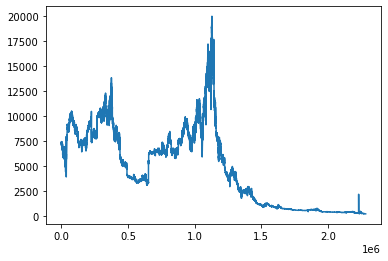

In [7]:
df["Close"].plot()

In [8]:
#Check null values
df.isnull().sum().sum()

0

In [9]:
#Check data types
df.dtypes

Unix Timestamp      int64
Date               object
Symbol             object
Open              float64
High              float64
Low               float64
Close             float64
Volume            float64
dtype: object

In [10]:
# Convert date to datetime
df['Date'] = pd.to_datetime(df['Date'])
df['Close'] = pd.to_numeric(df['Close'])

In [11]:
df.dtypes

Unix Timestamp             int64
Date              datetime64[ns]
Symbol                    object
Open                     float64
High                     float64
Low                      float64
Close                    float64
Volume                   float64
dtype: object

# Feature Engineering

In [12]:
#set date as index
df = df.set_index('Date')
df.head()

,Unix Timestamp,Symbol,Open,High,Low,Close,Volume
Date,,,,,,,
2020-04-09 00:00:00,1586390400000,BTCUSD,7369.60,7369.60,7348.47,7350.41,7.733528
2020-04-08 23:59:00,1586390340000,BTCUSD,7364.37,7369.60,7364.37,7369.60,1.310954
2020-04-08 23:58:00,1586390280000,BTCUSD,7360.89,7367.18,7360.89,7364.37,1.018774
2020-04-08 23:57:00,1586390220000,BTCUSD,7357.62,7366.12,7357.62,7360.89,0.026251
2020-04-08 23:56:00,1586390160000,BTCUSD,7370.71,7370.71,7357.62,7357.62,0.444867


### Percent Change

In [13]:
#Percent change for each variable
df['open_%_change'] = df['Open'].pct_change()
df['high_%_change'] = df['High'].pct_change()
df['low_%_change'] = df['Low'].pct_change()
df['close_%_change'] = df['Close'].pct_change()
df['volume_%_change'] = df['Volume'].pct_change()
df.head()

,Unix Timestamp,Symbol,Open,High,Low,Close,Volume,open_%_change,high_%_change,low_%_change,close_%_change,volume_%_change
Date,,,,,,,,,,,,
2020-04-09 00:00:00,1586390400000,BTCUSD,7369.60,7369.60,7348.47,7350.41,7.733528,NaN,NaN,NaN,NaN,NaN
2020-04-08 23:59:00,1586390340000,BTCUSD,7364.37,7369.60,7364.37,7369.60,1.310954,-0.000710,0.000000,0.002164,0.002611,-0.830484
2020-04-08 23:58:00,1586390280000,BTCUSD,7360.89,7367.18,7360.89,7364.37,1.018774,-0.000473,-0.000328,-0.000473,-0.000710,-0.222876
2020-04-08 23:57:00,1586390220000,BTCUSD,7357.62,7366.12,7357.62,7360.89,0.026251,-0.000444,-0.000144,-0.000444,-0.000473,-0.974233
2020-04-08 23:56:00,1586390160000,BTCUSD,7370.71,7370.71,7357.62,7357.62,0.444867,0.001779,0.000623,0.000000,-0.000444,15.946822


### Getting the 20mins simple moving average

In [14]:
df['60_min_sma_close'] = df['Close'].rolling(window=60).mean()
df.head()

,Unix Timestamp,Symbol,Open,High,Low,Close,Volume,open_%_change,high_%_change,low_%_change,close_%_change,volume_%_change,60_min_sma_close
Date,,,,,,,,,,,,,
2020-04-09 00:00:00,1586390400000,BTCUSD,7369.60,7369.60,7348.47,7350.41,7.733528,NaN,NaN,NaN,NaN,NaN,NaN
2020-04-08 23:59:00,1586390340000,BTCUSD,7364.37,7369.60,7364.37,7369.60,1.310954,-0.000710,0.000000,0.002164,0.002611,-0.830484,NaN
2020-04-08 23:58:00,1586390280000,BTCUSD,7360.89,7367.18,7360.89,7364.37,1.018774,-0.000473,-0.000328,-0.000473,-0.000710,-0.222876,NaN
2020-04-08 23:57:00,1586390220000,BTCUSD,7357.62,7366.12,7357.62,7360.89,0.026251,-0.000444,-0.000144,-0.000444,-0.000473,-0.974233,NaN
2020-04-08 23:56:00,1586390160000,BTCUSD,7370.71,7370.71,7357.62,7357.62,0.444867,0.001779,0.000623,0.000000,-0.000444,15.946822,NaN


### Visualizing the price and the 60-minute SMA

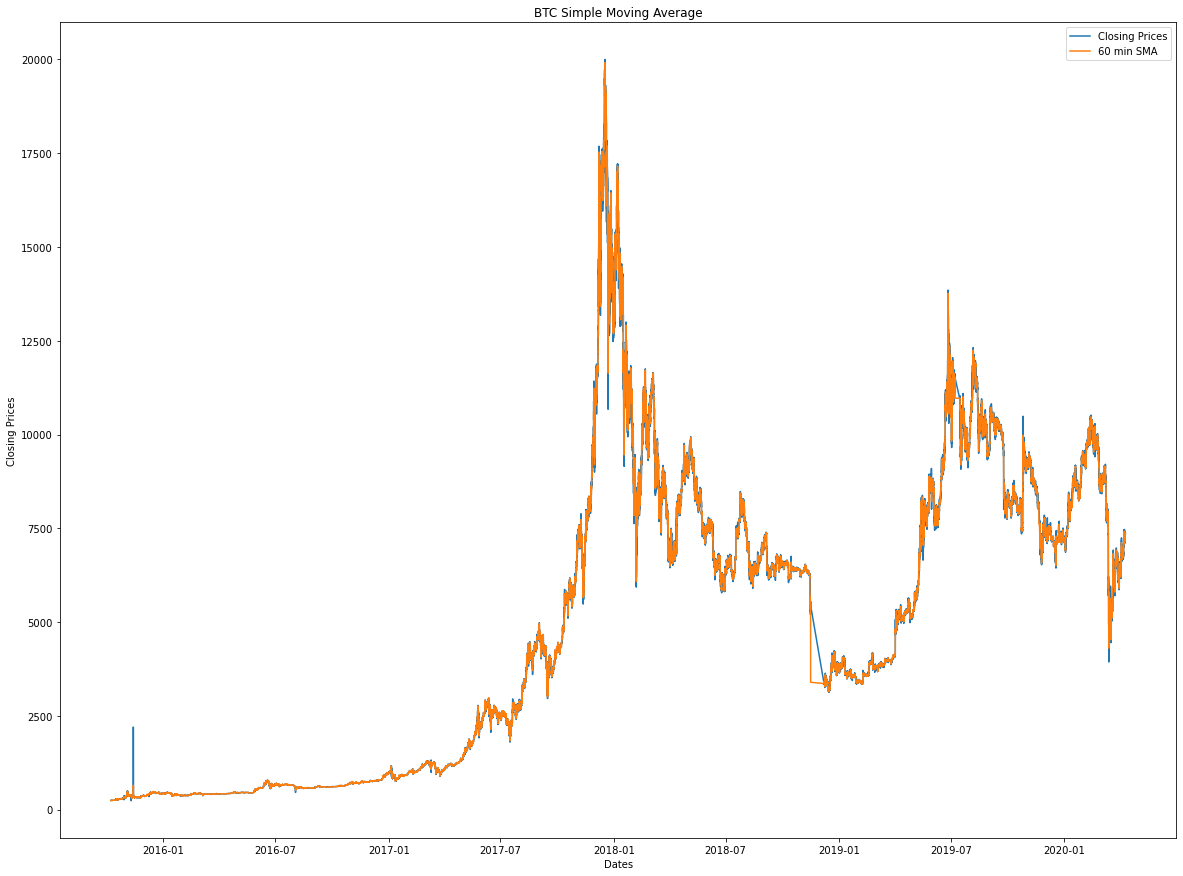

In [15]:
# Plot the simple moving average for 20 min
plt.figure(figsize =(20,15))
plt.title('BTC Simple Moving Average')
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df['Close'], label='Closing Prices')
plt.plot(df['60_min_sma_close'], label='60 min SMA')
plt.legend()
plt.show()

### Creating the upper and lower bands from the 60min moving average 

In [16]:
# two standard deviation away from the 20 min moving average
df['Upper Band_2'] = df['60_min_sma_close'] + (2 * df['Close'].rolling(window=60).std())
df['Lower Band_2'] = df['60_min_sma_close'] - (2 * df['Close'].rolling(window=60).std())
df.head()

,Unix Timestamp,Symbol,Open,High,Low,Close,Volume,open_%_change,high_%_change,low_%_change,close_%_change,volume_%_change,60_min_sma_close,Upper Band_2,Lower Band_2
Date,,,,,,,,,,,,,,,
2020-04-09 00:00:00,1586390400000,BTCUSD,7369.60,7369.60,7348.47,7350.41,7.733528,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-04-08 23:59:00,1586390340000,BTCUSD,7364.37,7369.60,7364.37,7369.60,1.310954,-0.000710,0.000000,0.002164,0.002611,-0.830484,NaN,NaN,NaN
2020-04-08 23:58:00,1586390280000,BTCUSD,7360.89,7367.18,7360.89,7364.37,1.018774,-0.000473,-0.000328,-0.000473,-0.000710,-0.222876,NaN,NaN,NaN
2020-04-08 23:57:00,1586390220000,BTCUSD,7357.62,7366.12,7357.62,7360.89,0.026251,-0.000444,-0.000144,-0.000444,-0.000473,-0.974233,NaN,NaN,NaN
2020-04-08 23:56:00,1586390160000,BTCUSD,7370.71,7370.71,7357.62,7357.62,0.444867,0.001779,0.000623,0.000000,-0.000444,15.946822,NaN,NaN,NaN


In [17]:
def bb_strategy(data, lower_bb, upper_bb):
    buy = []
    sell = []
    b_signal = []
    signal = 0
    
    for i in range(len(data)):
        if data[i-1] > lower_bb[i-1] and data[i] < lower_bb[i]:
            if signal != 1:
                buy.append(data[i])
                sell.append(np.nan)
                signal = 1
                b_signal.append(signal)
            else:
                buy.append(np.nan)
                sell.append(np.nan)
                b_signal.append(0)
        elif data[i-1] < upper_bb[i-1] and data[i] > upper_bb[i]:
            if signal != -1:
                buy.append(np.nan)
                sell.append(data[i])
                signal = -1
                b_signal.append(signal)
            else:
                buy.append(np.nan)
                sell.append(np.nan)
                b_signal.append(0)
        else:
            buy.append(np.nan)
            sell.append(np.nan)
            b_signal.append(0)
            
    return buy, sell, b_signal

buy, sell, b_signal = bb_strategy(df['Close'], df['Lower Band_2'], df['Upper Band_2'])

# SMAC

In [18]:
smac = df['Close'].values

In [19]:
short_lb = 9 
long_lb = 21
signal_df = pd.DataFrame(index=df.index)
#Setting signal to zero
signal_df['signal'] = 0.0
# Using the short_1b as the window value in price to create short moving average 
signal_df['short_mav'] = df[['Close']].rolling(window=short_lb,min_periods=1, center=False).mean()

In [20]:
# Using the long_1b as the window value in price to create long moving average 
signal_df['long_mav'] = df[['Close']].rolling(window=long_lb, min_periods=1, center=False).mean()

In [21]:
signal_df['signal'][short_lb:] = np.where(signal_df['short_mav'][short_lb:] > signal_df['long_mav'][short_lb:], 1.0, 0.0)   

In [22]:
signal_df['positions'] = signal_df['signal'].diff()
signal_df[signal_df['positions'] == -1.0]

,signal,short_mav,long_mav,positions
Date,,,,
2020-04-08 23:23:00,0.0,7387.911111,7387.913333,-1.0
2020-04-08 22:46:00,0.0,7366.197778,7366.685714,-1.0
2020-04-08 22:06:00,0.0,7353.776667,7353.934762,-1.0
2020-04-08 21:23:00,0.0,7357.260000,7358.383810,-1.0
2020-04-08 21:02:00,0.0,7353.583333,7353.935238,-1.0
...,...,...,...,...
2015-10-08 17:13:00,0.0,244.020000,244.020000,-1.0
2015-10-08 17:09:00,0.0,244.020000,244.020000,-1.0
2015-10-08 16:08:00,0.0,244.854444,244.855714,-1.0


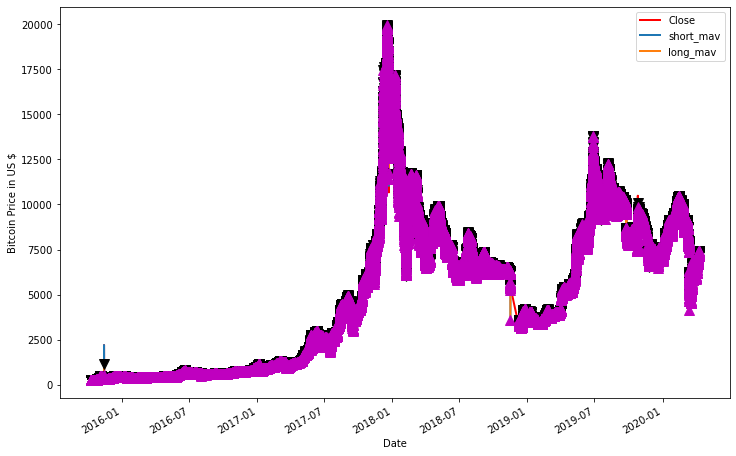

In [23]:
fig = plt.figure()
plt1 = fig.add_subplot(111,  ylabel='Bitcoin Price in US $')
df[['Close']].plot(ax=plt1, color='r', lw=2.)

signal_df[['short_mav', 'long_mav']].plot(ax=plt1, lw=2., figsize=(12,8))
plt1.plot(signal_df.loc[signal_df.positions == -1.0].index,signal_df.short_mav[signal_df.positions == -1.0],'v',                     markersize=10, color='k')
plt1.plot(signal_df.loc[signal_df.positions == 1.0].index,signal_df.short_mav[signal_df.positions == 1.0],'^', markersize=10, color='m')         # Show the plotplt.show()


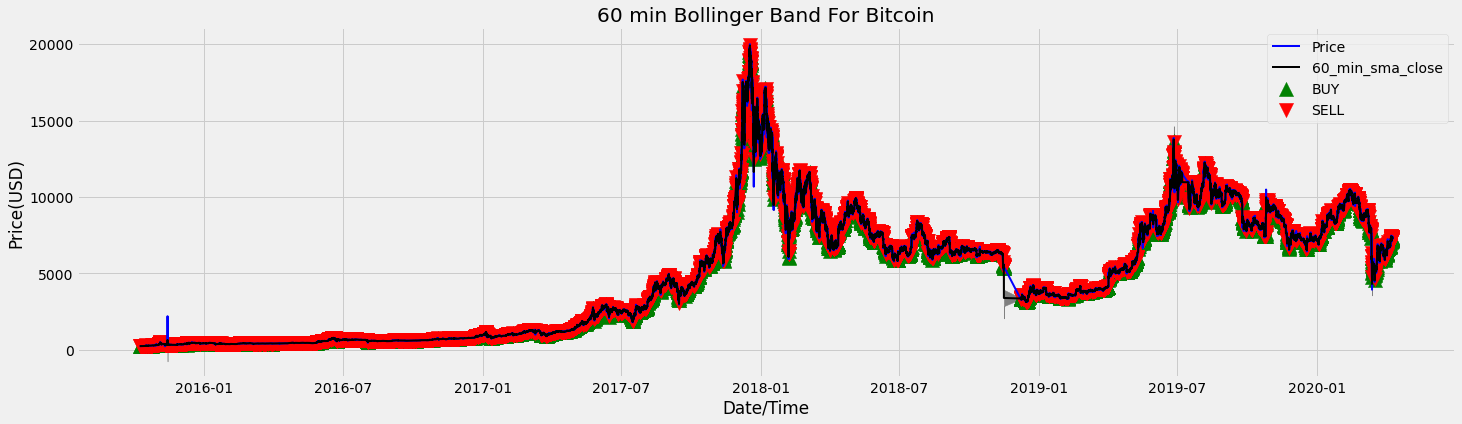

In [24]:
# set style, empty figure and axes
plt.style.use('fivethirtyeight')
fig = plt.figure(figsize=(22,6))
ax = fig.add_subplot(111)

# Get index values for the X axis 
x_axis = df.index.get_level_values(0)

# Plot shaded 21 Day Bollinger Band 
ax.fill_between(x_axis, df['Upper Band_2'], df['Lower Band_2'], color='grey')

# Plot Adjust Closing Price and Moving Averages
ax.plot(x_axis, df['Close'], color='blue', label = 'Price', lw=2)
ax.plot(x_axis, df['60_min_sma_close'], color='black', label = '60_min_sma_close', lw=2)

plt.scatter(df.index, buy, marker = '^', color = 'green', label = 'BUY', s = 200)

plt.scatter(df.index, sell, marker = 'v', color = 'red', label = 'SELL', s = 200)
# Set Title & Show the Image
ax.set_title('60 min Bollinger Band For Bitcoin')
ax.set_xlabel('Date/Time')
ax.set_ylabel('Price(USD)')
ax.legend()
plt.show();

In [25]:
df.isnull().sum().sum()

651258

In [26]:
df.shape

(2283519, 15)

# RESULTS: QUANTIFIED AUTOMATED TRADING PERFORMANCE

In [27]:
# initial trading capital
trad_capital= float(1000)

positions = pd.DataFrame(index=signal_df.index).fillna(0.0)

#Buy a 1000 USD in Bitcoins
positions['Position ($)'] = signal_df['signal']

portfolio = positions.multiply(df['Close'], axis = 0)

pos_diff = positions.diff()

portfolio['holdings'] = (positions.multiply(df['Close'], axis = 0)).sum(axis = 1)

portfolio['cash'] = trad_capital - (pos_diff.multiply(df['Close'],axis = 0)).sum(axis = 1).cumsum()

portfolio['total'] = portfolio['cash'] + portfolio['holdings']

In [28]:
signal_df.head()

,signal,short_mav,long_mav,positions
Date,,,,
2020-04-09 00:00:00,0.0,7350.4100,7350.4100,NaN
2020-04-08 23:59:00,0.0,7360.0050,7360.0050,0.0
2020-04-08 23:58:00,0.0,7361.4600,7361.4600,0.0
2020-04-08 23:57:00,0.0,7361.3175,7361.3175,0.0
2020-04-08 23:56:00,0.0,7360.5780,7360.5780,0.0


In [29]:
portfolio ['returns'] = portfolio['total'].pct_change()

In [30]:
del portfolio['Position ($)']

print(portfolio.head())
print(portfolio.tail())

                     holdings    cash   total  returns
Date                                                  
2020-04-09 00:00:00       0.0  1000.0  1000.0      NaN
2020-04-08 23:59:00       0.0  1000.0  1000.0      0.0
2020-04-08 23:58:00       0.0  1000.0  1000.0      0.0
2020-04-08 23:57:00       0.0  1000.0  1000.0      0.0
2020-04-08 23:56:00       0.0  1000.0  1000.0      0.0
                     holdings           cash          total  returns
Date                                                                
2015-10-08 13:44:00       0.0 -129681.296036 -129681.296036      0.0
2015-10-08 13:43:00       0.0 -129681.296036 -129681.296036      0.0
2015-10-08 13:42:00       0.0 -129681.296036 -129681.296036      0.0
2015-10-08 13:41:00       0.0 -129681.296036 -129681.296036      0.0
2015-10-08 13:40:00       0.0 -129681.296036 -129681.296036      0.0


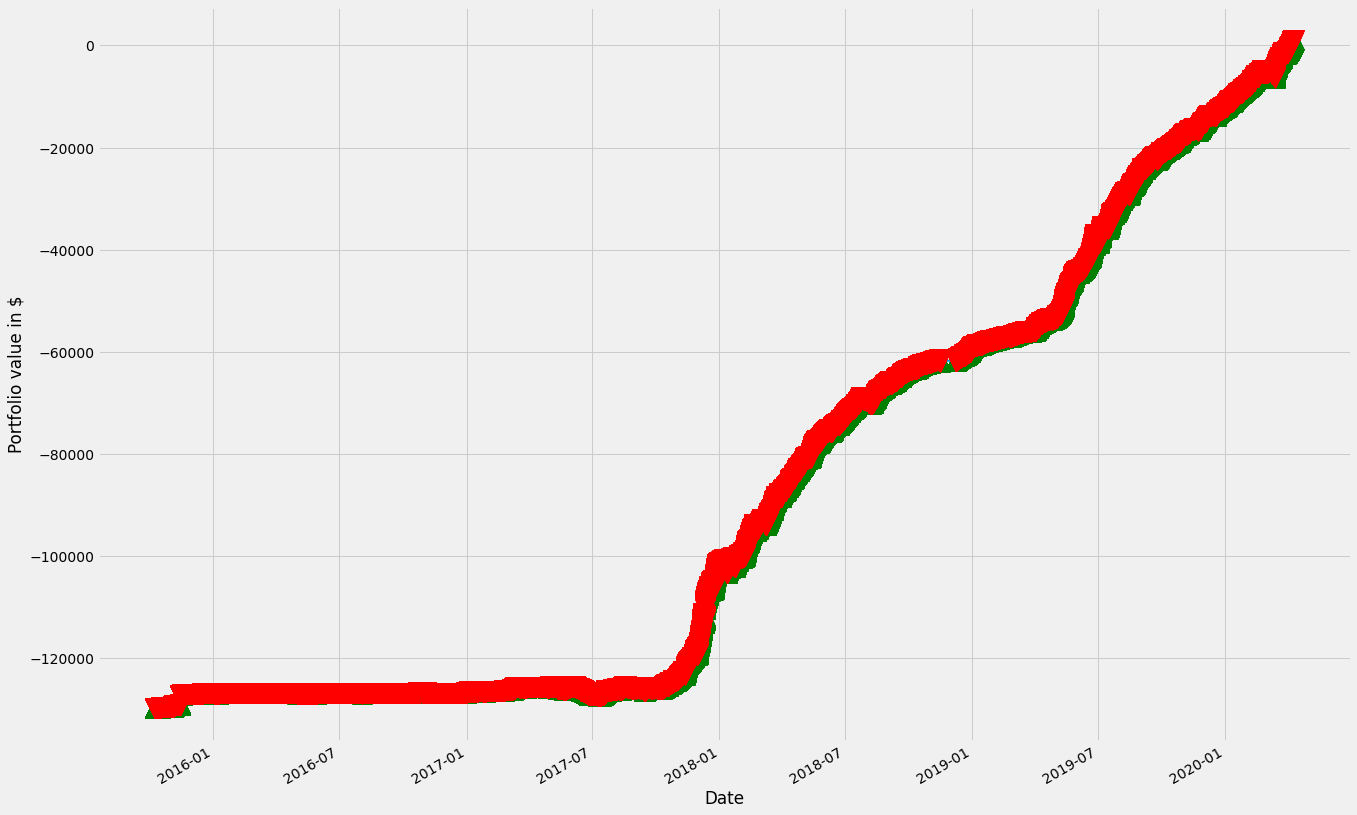

In [31]:
fig = plt.figure(figsize =(20,15))

ax1 = fig.add_subplot(111, ylabel='Portfolio value in $')

portfolio['total'].plot(ax=ax1, lw=2.)

ax1.plot(portfolio.loc[signal_df.positions == 1.0].index,portfolio.total[signal_df.positions == 1.0], '^', markersize = 20, color = 'g')

ax1.plot(portfolio.loc[signal_df.positions == -1.0].index,portfolio.total[signal_df.positions == -1.0], 'v', markersize = 20, color = 'r')

plt.show()

In [32]:
print('Portfolio Total Value as of 2015-10-08 ')
print(portfolio['total'].tail(1))

print('Absolute return as of 2020-04-09 ')

print((((portfolio['total'].head(1)/float(1000)) - float(1))*100))

Portfolio Total Value as of 2015-10-08 
Date
2015-10-08 13:40:00   -129681.296036
Name: total, dtype: float64
Absolute return as of 2020-04-09 
Date
2020-04-09    0.0
Name: total, dtype: float64


In [33]:
# replacing all the missing values with 0
df.fillna(0,inplace = True)

# Arima Model

### First, Check for stationarity

In [34]:
# result = adfuller(df['Close'])
# print('ADF Statistic: %f' % result[0])
# print('p-value: %f' % result[1])

# Model building

### Auto-correlation plot

In [35]:
#Resampling the data using mean
df_sampled = df.resample("BM").mean()
df_sampled.head()

,Unix Timestamp,Open,High,Low,Close,Volume,open_%_change,high_%_change,low_%_change,close_%_change,volume_%_change,60_min_sma_close,Upper Band_2,Lower Band_2
Date,,,,,,,,,,,,,,
2015-10-30,1.445281e+09,272.517825,272.552324,272.493771,272.528053,0.315693,-0.000037,-0.000007,-0.000038,-0.000006,inf,272.606959,273.639586,271.574332
2015-11-30,1.447589e+09,349.248233,349.381850,349.116129,349.249282,0.656070,0.000111,0.000106,0.000110,0.000111,inf,349.280790,354.411467,344.150113
2015-12-31,1.450267e+09,423.096865,423.141559,423.053798,423.098046,0.333863,-0.000001,-0.000001,-0.000001,-0.000001,inf,423.132196,425.150783,421.113609
2016-01-29,1.452859e+09,413.696836,413.732481,413.660653,413.695619,0.699188,0.000004,0.000004,0.000004,0.000004,inf,413.659613,415.341686,411.977540
2016-02-29,1.455451e+09,400.367362,400.383248,400.353280,400.368681,0.658288,-0.000003,-0.000003,-0.000003,-0.000003,inf,400.407746,401.255108,399.560384


<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

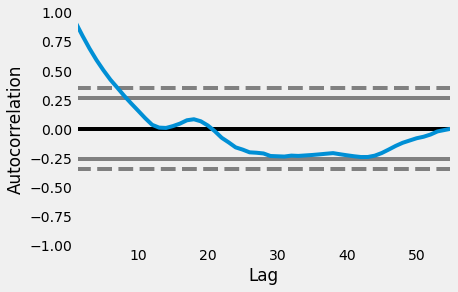

In [36]:
# Autocorrelation plot
autocorrelation_plot(df_sampled["Close"])

***We can see from the plot that about more than 50% of the data line shows a significant correlation with time. So in this case, a Recurrent Neural Network output will be efficient in Forecasting the Prices.***

# Seasonal plot

C:\Users\kakin\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


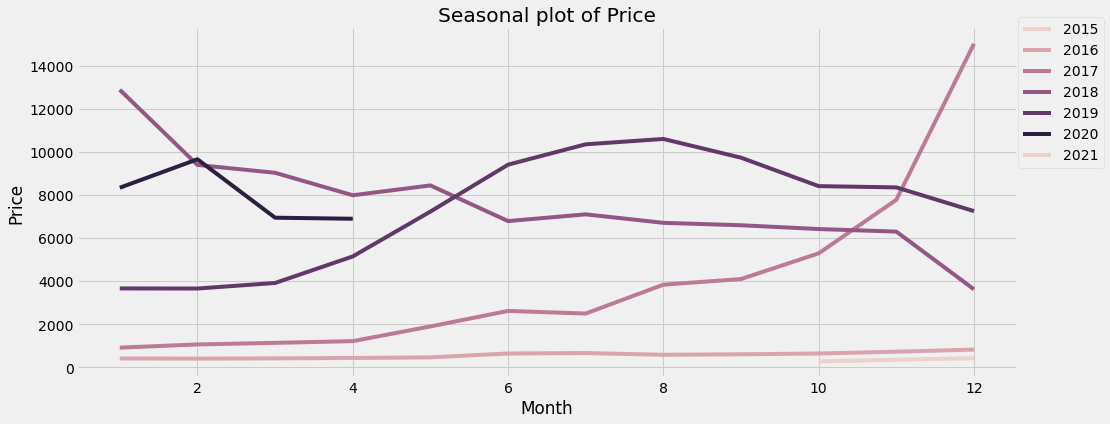

In [37]:
import seaborn as sns
#Creating Month and Year features from Date
df['Date'] = pd.to_datetime(df.index)
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month

plt.style.use("fivethirtyeight")
variable = 'Close'
fig, ax = plt.subplots(figsize=(15, 6))
sns.lineplot(df['Month'], df[variable], hue = df['Year'])
ax.set_title('Seasonal plot of Price', loc='center')
ax.set_xlabel('Month')
ax.set_ylabel('Price')
ax.legend(labels = [str(2015+i) for i in range(7)], bbox_to_anchor=(1.1, 1.05))

 ***From the plot, we can see a high bitcoin price after the month of june then a slight drop. Similar to other years except for 2020 and 2015. In 2017, there was an upward trend in price.***   

<ipython-input-38-dca8c2ab2f7b>:15: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  decomposition = sm.tsa.seasonal_decompose(y, model='multiplicative', freq = 12)


<bound method Figure.get_size_inches of <Figure size 1080x864 with 4 Axes>>


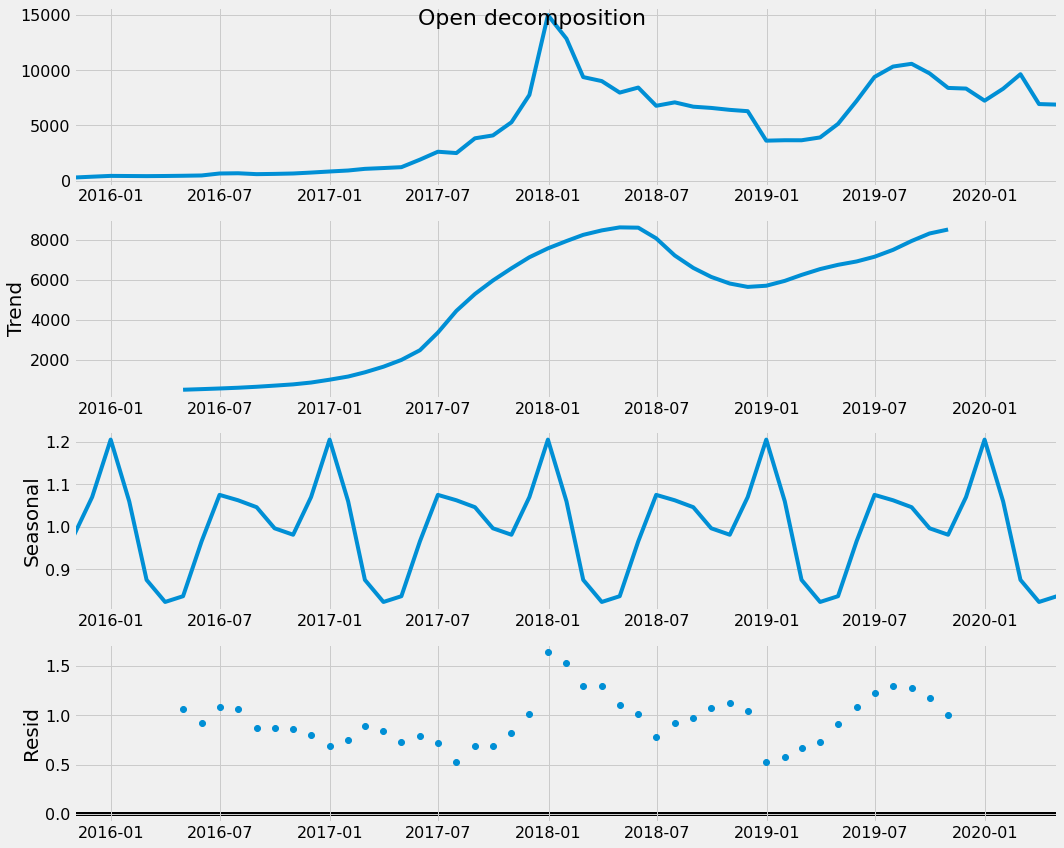

In [38]:
from pylab import rcParams
import statsmodels.api as sm

plt.style.use("fivethirtyeight")
y = df[['Date','Open']].copy()
y.set_index('Date', inplace=True)
y.index = pd.to_datetime(y.index)
y = y.resample("1M").mean()

rcParams['figure.figsize'] = 15, 12
rcParams['axes.labelsize'] = 20
rcParams['ytick.labelsize'] = 16
rcParams['xtick.labelsize'] = 16

decomposition = sm.tsa.seasonal_decompose(y, model='multiplicative', freq = 12)
decomp = decomposition.plot()
decomp.suptitle('Open decomposition', fontsize=22)
print(decomp.get_size_inches)

***Trend, Seasonal, and Residual plots to show the recurring variations i.e. the ups and downs of time-series data, pattern across the season and the resudual.***

In [39]:
df.columns

Index(['Unix Timestamp', 'Symbol', 'Open', 'High', 'Low', 'Close', 'Volume',
       'open_%_change', 'high_%_change', 'low_%_change', 'close_%_change',
       'volume_%_change', '60_min_sma_close', 'Upper Band_2', 'Lower Band_2',
       'Date', 'Year', 'Month'],
      dtype='object')

# LONG SHORT-TERM MEMORY(LSTM)

### Normalization

In [40]:
df1=df['Close']

In [52]:
from keras.layers import Dense, Embedding 

# Start here

# Using the LSTM on the relative price change

# Preprocessing on relative price data

# LSTM on absolute price 

In [99]:
df_features = df[['Close', 'Open', 'High', 'Low', 'Volume']]


In [100]:

df_features['abs_close_price'] = df_features['Close'] - df_features['Close'].shift(1)

<ipython-input-100-55dda024d441>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_features['abs_close_price'] = df_features['Close'] - df_features['Close'].shift(1)


In [101]:

df_features['abs_open_price'] = df_features['Open'] - df_features['Open'].shift(1)
df_features['abs_high_price'] = df_features['High'] - df_features['High'].shift(1)
df_features['abs_low_price'] = df_features['Low'] - df_features['Low'].shift(1)
df_features['abs_volume'] = df_features['Volume'] - df_features['Volume'].shift(1)

<ipython-input-101-1b46b051a101>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_features['abs_open_price'] = df_features['Open'] - df_features['Open'].shift(1)
<ipython-input-101-1b46b051a101>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_features['abs_high_price'] = df_features['High'] - df_features['High'].shift(1)
<ipython-input-101-1b46b051a101>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

In [102]:
df_features['60_min_sma_volume_change'] = df_features['abs_volume'].rolling(window=60).mean()
df_features['60_min_sma_open_change'] = df_features['abs_open_price'].rolling(window=60).mean()
df_features['60_min_sma_high_change'] = df_features['abs_high_price'].rolling(window=60).mean()
df_features['60_min_sma_low_change'] = df_features['abs_low_price'].rolling(window=60).mean()
df_features['60_min_sma_close_change'] = df_features['abs_close_price'].rolling(window=60).mean()

<ipython-input-102-8337d135c310>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_features['60_min_sma_volume_change'] = df_features['abs_volume'].rolling(window=60).mean()
<ipython-input-102-8337d135c310>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_features['60_min_sma_open_change'] = df_features['abs_open_price'].rolling(window=60).mean()
<ipython-input-102-8337d135c310>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col

# Features selection

In [105]:
df_features = df_features[['60_min_sma_volume_change', '60_min_sma_open_change',
       '60_min_sma_high_change', '60_min_sma_low_change',
       '60_min_sma_close_change']]

In [106]:
df_features.fillna(0, inplace = True)

C:\Users\kakin\anaconda3\lib\site-packages\pandas\core\frame.py:4462: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


In [320]:
df_features.head()

,Close,Open,High,Low,Volume,abs_close_price,abs_open_price,abs_high_price,abs_low_price,abs_volume,30_min_sma_close_change,30_min_sma_volume_change,30_min_sma_open_change,30_min_sma_high_change,30_min_sma_low_change
Date,,,,,,,,,,,,,,,
2020-04-09 00:00:00,7350.41,7369.60,7369.60,7348.47,7.733528,0.00,0.00,0.00,0.00,0.000000,0.0,0.0,0.0,0.0,0.0
2020-04-08 23:59:00,7369.60,7364.37,7369.60,7364.37,1.310954,19.19,-5.23,0.00,15.90,-6.422573,0.0,0.0,0.0,0.0,0.0
2020-04-08 23:58:00,7364.37,7360.89,7367.18,7360.89,1.018774,-5.23,-3.48,-2.42,-3.48,-0.292180,0.0,0.0,0.0,0.0,0.0
2020-04-08 23:57:00,7360.89,7357.62,7366.12,7357.62,0.026251,-3.48,-3.27,-1.06,-3.27,-0.992524,0.0,0.0,0.0,0.0,0.0
2020-04-08 23:56:00,7357.62,7370.71,7370.71,7357.62,0.444867,-3.27,13.09,4.59,0.00,0.418616,0.0,0.0,0.0,0.0,0.0


In [307]:
# Training set
training_size_0 =int(len(df_features)*0.65)

# Test set
test_size_0=len(df_features)-training_size_0

train_data_0,test_data_0=df_features[0:training_size_0],df_features[training_size_0:len(df_features)]

In [110]:
print(train_data_0.shape)
print(test_data_0.shape)

(1484287, 5)
(799232, 5)


# Scalling

In [112]:
# Scaling the training data
scaler_0 = MinMaxScaler()

data_training_0 = scaler_0.fit_transform(train_data_0)
data_training_0[0:5]

array([[0.50298713, 0.51472298, 0.49104844, 0.50689905, 0.51472298],
       [0.50298713, 0.51472298, 0.49104844, 0.50689905, 0.51472298],
       [0.50298713, 0.51472298, 0.49104844, 0.50689905, 0.51472298],
       [0.50298713, 0.51472298, 0.49104844, 0.50689905, 0.51472298],
       [0.50298713, 0.51472298, 0.49104844, 0.50689905, 0.51472298]])

In [113]:
X_train_0 = []
y_train_0 = []

# SPLITTING THE TRAINING SET INTO X AND Y

In [115]:
for i in range(60, data_training_0.shape[0]):
    X_train_0.append(data_training_0[i-60:i])
    y_train_0.append(data_training_0[i, 0])

In [116]:
X_train_0, y_train_0 = np.array(X_train_0), np.array(y_train_0)


In [118]:

print(X_train_0.shape)
print(y_train_0.shape)

(1484227, 60, 5)
(1484227,)


# Model building

In [119]:
model_0 = Sequential()

model_0.add(LSTM(units = 60, activation = 'relu', return_sequences = True, input_shape = (X_train_0.shape[1], 5)))
model_0.add(Dropout(0.2))

model_0.add(LSTM(units = 60, activation = 'relu', return_sequences = True))
model_0.add(Dropout(0.2))

model_0.add(LSTM(units = 80, activation = 'relu', return_sequences = True))
model_0.add(Dropout(0.2))

model_0.add(LSTM(units = 120, activation = 'relu'))
model_0.add(Dropout(0.2))

model_0.add(Dense(units = 1))

In [120]:
model_0.compile(optimizer='adam', loss = 'mean_squared_error')


# MODEL FIT

In [121]:
model_0.fit(X_train_0, y_train_0, epochs=5, batch_size=32)


Epoch 1/5
46383/46383 [==============================] - 6468s 139ms/step - loss: 1.0320e-04
Epoch 2/5
46383/46383 [==============================] - 6204s 134ms/step - loss: 3.2335e-06
Epoch 3/5
46383/46383 [==============================] - 4766s 103ms/step - loss: 3.2340e-06
Epoch 4/5
46383/46383 [==============================] - 4823s 104ms/step - loss: 3.2307e-06
Epoch 5/5
46383/46383 [==============================] - 4801s 104ms/step - loss: 3.2347e-06


In [122]:
test_data_0.head()

,60_min_sma_volume_change,60_min_sma_open_change,60_min_sma_high_change,60_min_sma_low_change,60_min_sma_close_change
Date,,,,,
2017-04-15 14:11:00,-4.221312e-02,-0.094833,-0.094833,-0.094833,-0.094833
2017-04-15 14:10:00,-4.151008e-03,-0.094833,-0.094833,-0.094833,-0.094833
2017-04-15 14:09:00,-1.980518e-04,-0.094833,-0.094833,-0.094833,-0.094833
2017-04-15 14:08:00,-1.365713e-14,-0.094833,-0.094833,-0.094833,-0.094833
2017-04-15 14:07:00,3.877231e-02,-0.112333,-0.094833,-0.112333,-0.094833


In [123]:

past_60_days_0 = train_data_0.tail(60)

df_0 = past_60_days_0.append(test_data_0)
# df = df.drop(['Date', 'Adj Close'], axis = 1)
df_0.head()

,60_min_sma_volume_change,60_min_sma_open_change,60_min_sma_high_change,60_min_sma_low_change,60_min_sma_close_change
Date,,,,,
2017-04-15 15:11:00,0.031826,-0.005,-0.005,-0.005,-0.005
2017-04-15 15:10:00,0.005579,-0.005,-0.005,-0.005,-0.005
2017-04-15 15:09:00,0.000494,-0.005,-0.005,-0.005,-0.005
2017-04-15 15:08:00,-0.001952,-0.005,-0.005,-0.005,-0.005
2017-04-15 15:07:00,0.000802,-0.005,-0.005,-0.005,-0.005


# SCALLING THE DATA

In [124]:
inputs_0 = scaler_0.transform(df_0)
inputs_0

array([[0.50310335, 0.51465717, 0.49097941, 0.50683539, 0.51465717],
       [0.50300751, 0.51465717, 0.49097941, 0.50683539, 0.51465717],
       [0.50298894, 0.51465717, 0.49097941, 0.50683539, 0.51465717],
       ...,
       [0.50298713, 0.51428427, 0.49058827, 0.50647469, 0.51428427],
       [0.50297215, 0.51418556, 0.49058827, 0.5063792 , 0.51428427],
       [0.50299018, 0.46099244, 0.49048473, 0.45492545, 0.51418556]])

# SPLITTING THE TEST SET INTO X AND Y

In [125]:
X_test_0 = []
y_test_0 = []

for i in range(60, inputs_0.shape[0]):
    X_test_0.append(inputs_0[i-60:i])
    y_test_0.append(inputs_0[i, 0])

In [126]:
X_test_0, y_test_0 = np.array(X_test_0), np.array(y_test_0)
X_test_0.shape, y_test_0.shape

((799232, 60, 5), (799232,))

In [260]:
y_test_0

array([137.69870492, 137.73676708, 137.74072004, ..., 137.7409181 ,
       137.73681604, 137.74175143])

In [293]:
y_pred_0 = model_0.predict(X_test_0)


In [294]:
y_pred_0

array([[0.5031272],
       [0.5031272],
       [0.5031272],
       ...,
       [0.5031272],
       [0.5031272],
       [0.5031272]], dtype=float32)

In [295]:
scaler_0.scale_


array([0.00365169, 0.01316119, 0.01380526, 0.01273083, 0.01316119])

In [129]:
scale_0 = 1/0.00365169
scale_0

273.84580837913404

# TRANSFORMING THE SCALED DATA

In [130]:
y_pred_0 = y_pred_0*scale_0
y_test_0 = y_test_0*scale_0

In [272]:
y_test_01 = pd.DataFrame(y_test_0)
y_pred_01 = pd.DataFrame(y_pred_0)

In [310]:
y_pred_01.head()

,0
0,137.779266
1,137.779266
2,137.779266
3,137.779266
4,137.779266


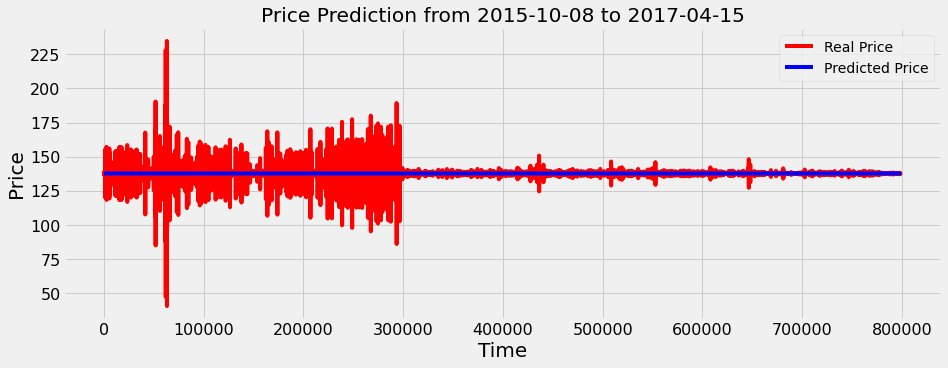

In [290]:
# Visualising the results
plt.figure(figsize=(14,5))
plt.plot(y_test_0, color = 'red', label = 'Real Price')
plt.plot(y_pred_0, color = 'blue', label = 'Predicted Price')
plt.title('Price Prediction from 2015-10-08 to 2017-04-15')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [311]:
# model_0.evaluate(X_test_0, y_pred_0, batch_size = 32)

# MODEL PERFORMANCE

### RELATIVE MEAN SQUARE ERROR

In [316]:
print('RMSE',np.sqrt(metrics.mean_squared_error(y_test_0, y_pred_0)))


RMSE 137.23873256409038


### MODEL ACCURACY

In [287]:
print((1-(metrics.mean_absolute_error(y_test_0, y_pred_0)/y_test_0.mean()))*100)

99.948461531033


### MEAN SQUARED ERROR

In [284]:
print('MSE', metrics.mean_squared_error(y_test_0, y_pred_0))

MSE 0.26026684414236334


### MEAN ABSOLUTE ERROR

In [283]:
from sklearn import metrics
print('MAE in %', (metrics.mean_absolute_error(y_test_0, y_pred_0)/y_test_0.mean())*100)


MAE in % 0.051538468966995106


MAE in % 0.032710496910332204


In [280]:
X_test_0.shape

(799232, 60, 5)

# Building an LSTM model for 30min SMA of absolute change

In [135]:
df_features = df[['Close', 'Open', 'High', 'Low', 'Volume']]


In [136]:
df_features['abs_close_price'] = df_features['Close'] - df_features['Close'].shift(1)
df_features['abs_open_price'] = df_features['Open'] - df_features['Open'].shift(1)
df_features['abs_high_price'] = df_features['High'] - df_features['High'].shift(1)
df_features['abs_low_price'] = df_features['Low'] - df_features['Low'].shift(1)
df_features['abs_volume'] = df_features['Volume'] - df_features['Volume'].shift(1)

<ipython-input-136-906de283dad1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_features['abs_close_price'] = df_features['Close'] - df_features['Close'].shift(1)
<ipython-input-136-906de283dad1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_features['abs_open_price'] = df_features['Open'] - df_features['Open'].shift(1)
<ipython-input-136-906de283dad1>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

# 30 min moving average

In [137]:
df_features['30_min_sma_close_change'] = df_features['abs_close_price'].rolling(window=30).mean()
df_features['30_min_sma_volume_change'] = df_features['abs_volume'].rolling(window=30).mean()
df_features['30_min_sma_open_change'] = df_features['abs_open_price'].rolling(window=30).mean()
df_features['30_min_sma_high_change'] = df_features['abs_high_price'].rolling(window=30).mean()
df_features['30_min_sma_low_change'] = df_features['abs_low_price'].rolling(window=30).mean()

<ipython-input-137-852ebddb8b6f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_features['30_min_sma_close_change'] = df_features['abs_close_price'].rolling(window=30).mean()
<ipython-input-137-852ebddb8b6f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_features['30_min_sma_volume_change'] = df_features['abs_volume'].rolling(window=30).mean()
<ipython-input-137-852ebddb8b6f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

In [138]:
df_features

,Close,Open,High,Low,Volume,abs_close_price,abs_open_price,abs_high_price,abs_low_price,abs_volume,30_min_sma_close_change,30_min_sma_volume_change,30_min_sma_open_change,30_min_sma_high_change,30_min_sma_low_change
Date,,,,,,,,,,,,,,,
2020-04-09 00:00:00,7350.41,7369.60,7369.60,7348.47,7.733528,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-04-08 23:59:00,7369.60,7364.37,7369.60,7364.37,1.310954,19.19,-5.23,0.00,15.90,-6.422573,NaN,NaN,NaN,NaN,NaN
2020-04-08 23:58:00,7364.37,7360.89,7367.18,7360.89,1.018774,-5.23,-3.48,-2.42,-3.48,-0.292180,NaN,NaN,NaN,NaN,NaN
2020-04-08 23:57:00,7360.89,7357.62,7366.12,7357.62,0.026251,-3.48,-3.27,-1.06,-3.27,-0.992524,NaN,NaN,NaN,NaN,NaN
2020-04-08 23:56:00,7357.62,7370.71,7370.71,7357.62,0.444867,-3.27,13.09,4.59,0.00,0.418616,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-10-08 13:44:00,242.96,242.96,242.96,242.96,0.033491,0.00,0.00,0.00,0.00,0.033491,-0.051333,1.116371e-03,-0.051333,-0.051333,-0.051333
2015-10-08 13:43:00,242.96,242.95,242.96,242.95,0.010000,0.00,-0.01,0.00,-0.01,-0.023491,-0.051333,3.333333e-04,-0.051667,-0.051333,-0.051667
2015-10-08 13:42:00,242.95,242.95,242.95,242.95,0.000000,-0.01,0.00,-0.01,0.00,-0.010000,-0.051667,-9.746411e-14,-0.051667,-0.051667,-0.051667


In [139]:
df_features.fillna(0, inplace = True)

C:\Users\kakin\anaconda3\lib\site-packages\pandas\core\frame.py:4462: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


In [140]:
df_features_1 = df_features[['30_min_sma_volume_change', '30_min_sma_open_change',
       '30_min_sma_high_change', '30_min_sma_low_change',
       '30_min_sma_close_change']]

In [156]:
# Training set
training_size_1 =int(len(df_features_1)*0.65)

# Test set
test_size_1=len(df_features_1)-training_size_1

train_data_1,test_data_1=df_features_1[0:training_size_1],df_features_1[training_size_1:len(df_features_1)]

In [157]:
print(train_data_1.shape)
print(test_data_1.shape)

(1484287, 5)
(799232, 5)


In [158]:
# Scaling the training data
scaler_1 = MinMaxScaler()

data_training_1 = scaler_1.fit_transform(train_data_1)
data_training_1[0:5]

array([[0.49968522, 0.42315584, 0.40468744, 0.4131385 , 0.42315584],
       [0.49968522, 0.42315584, 0.40468744, 0.4131385 , 0.42315584],
       [0.49968522, 0.42315584, 0.40468744, 0.4131385 , 0.42315584],
       [0.49968522, 0.42315584, 0.40468744, 0.4131385 , 0.42315584],
       [0.49968522, 0.42315584, 0.40468744, 0.4131385 , 0.42315584]])

In [159]:
X_train_1 = []
y_train_1 = []

In [160]:
for i in range(60, data_training_1.shape[0]):
    X_train_1.append(data_training_1[i-60:i])
    y_train_1.append(data_training_1[i, 0])

In [161]:
X_train_1, y_train_1 = np.array(X_train_1), np.array(y_train_1)

print(X_train_1.shape)
print(y_train_1.shape)

(1484227, 60, 5)
(1484227,)


In [238]:
model_1 = Sequential()

model_1.add(LSTM(units = 60, activation = 'relu', return_sequences = True, input_shape = (X_train_1.shape[1], 5)))
model_1.add(Dropout(0.2))

model_1.add(LSTM(units = 60, activation = 'relu', return_sequences = True))
model_1.add(Dropout(0.2))

model_1.add(LSTM(units = 80, activation = 'relu', return_sequences = True))
model_1.add(Dropout(0.2))

model_1.add(LSTM(units = 120, activation = 'relu'))
model_1.add(Dropout(0.2))

model_1.add(Dense(units = 1))

In [148]:
model_1.compile(optimizer='adam', loss = 'mean_squared_error')


In [149]:
model_1.fit(X_train_1, y_train_1, epochs=5, batch_size=32)

Epoch 1/5
46383/46383 [==============================] - 8467s 182ms/step - loss: 9.6318e-05
Epoch 2/5
46383/46383 [==============================] - 5914s 128ms/step - loss: 3.1784e-06
Epoch 3/5
46383/46383 [==============================] - 4857s 105ms/step - loss: 3.1793e-06
Epoch 4/5
46383/46383 [==============================] - 4905s 106ms/step - loss: 3.1739e-06
Epoch 5/5
46383/46383 [==============================] - 5544s 120ms/step - loss: 3.1748e-06


In [163]:
test_data_1.head()

,30_min_sma_volume_change,30_min_sma_open_change,30_min_sma_high_change,30_min_sma_low_change,30_min_sma_close_change
Date,,,,,
2017-04-15 14:11:00,-5.691842e-14,-0.059667,-0.059667,-0.059667,-0.059667
2017-04-15 14:10:00,5.006723e-03,-0.059667,-0.059667,-0.059667,-0.059667
2017-04-15 14:09:00,-1.729055e-02,-0.059667,-0.059667,-0.059667,-0.059667
2017-04-15 14:08:00,-1.485616e-03,-0.059667,-0.059667,-0.059667,-0.059667
2017-04-15 14:07:00,7.914877e-02,-0.094667,-0.059667,-0.094667,-0.059667


In [208]:
# data_training = data[data['Date']<'2019-01-01'].copy()

past_60_days_1 = train_data_1.tail(60)

df_1 = past_60_days_1.append(test_data_1)
# df = df.drop(['Date', 'Adj Close'], axis = 1)
df_1.head()

,30_min_sma_volume_change,30_min_sma_open_change,30_min_sma_high_change,30_min_sma_low_change,30_min_sma_close_change
Date,,,,,
2017-04-15 15:11:00,8.442624e-02,0.023333,0.023333,0.023333,0.023333
2017-04-15 15:10:00,1.171325e-02,-0.010000,-0.010000,0.023333,0.023333
2017-04-15 15:09:00,9.877117e-04,-0.010000,-0.010000,-0.010000,-0.010000
2017-04-15 15:08:00,-5.705251e-14,-0.010000,-0.010000,-0.010000,-0.010000
2017-04-15 15:07:00,1.604159e-03,-0.010000,-0.010000,-0.010000,-0.010000


# Scalling data

In [165]:
inputs_1 = scaler_1.transform(df_1)
inputs_1

array([[0.49983855, 0.42334632, 0.40488397, 0.41332438, 0.42334632],
       [0.49970649, 0.4230742 , 0.40460321, 0.41332438, 0.42334632],
       [0.49968701, 0.4230742 , 0.40460321, 0.41305883, 0.4230742 ],
       ...,
       [0.49968522, 0.42273405, 0.40425227, 0.41272691, 0.42273405],
       [0.49968528, 0.4226116 , 0.40425227, 0.41260741, 0.42273405],
       [0.49968824, 0.35662233, 0.40412593, 0.34821343, 0.4226116 ]])

In [213]:
X_test_1 = []
y_test_1 = []

for i in range(60, inputs_1.shape[0]):
    X_test_1.append(inputs_1[i-60:i])
    y_test_1.append(inputs_1[i, 0])

In [214]:
X_test_1, y_test_1 = np.array(X_test_1), np.array(y_test_1)
X_test_1.shape, y_test_1.shape

((799232, 60, 5), (799232,))

In [217]:
y_pred_1 = model_1.predict(X_test_1)


In [169]:
scaler_1.scale_


array([0.00181619, 0.00816362, 0.00842257, 0.00796627, 0.00816362])

In [170]:
scale_1 = 1/0.00181619
scale_1

550.603185790033

In [176]:
X_test_11 = X_test_1*scale_1

# Transforming the scaled data

In [171]:
y_pred_1 = y_pred_1*scale_1
y_test_1 = y_test_1*scale_1

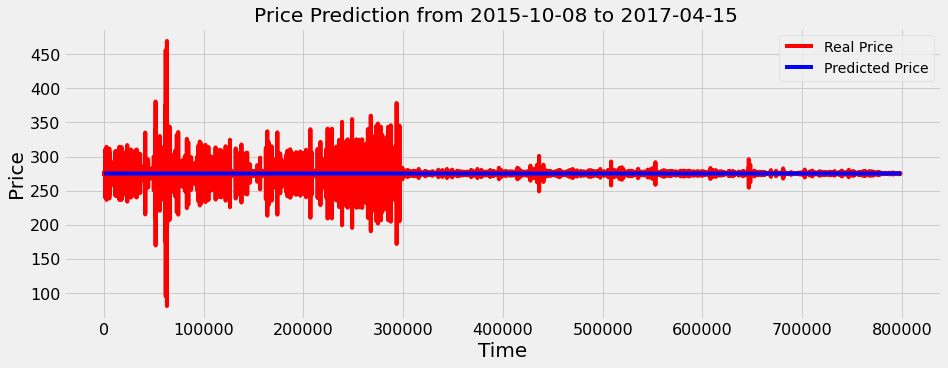

In [172]:
# Visualising the results
plt.figure(figsize=(14,5))
plt.plot(y_test_1, color = 'red', label = 'Real Price')
plt.plot(y_pred_1, color = 'blue', label = 'Predicted Price')
plt.title('Price Prediction from 2015-10-08 to 2017-04-15  ')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()


In [318]:
print('MSE', metrics.mean_squared_error(y_test_1, y_pred_1))
print('MAE in %', (metrics.mean_absolute_error(y_test_1, y_pred_1)/y_test_1.mean())*100)

MSE 3.413735659550736e-06
MAE in % 0.032710496910332204


In [319]:
model_1.evaluate(X_test_1, y_test_1, batch_size = 32)

24976/24976 [==============================] - 959s 38ms/step - loss: 3.4134e-06


3.4134011457354063e-06